In [0]:
import numpy as np
import random
import os 

from PIL import Image
from skimage import io

import torch 
from torch import  optim
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision import datasets

import matplotlib.pyplot as plt
%matplotlib inline

#### Download Data

In [0]:
# !wget --directory-prefix=data/  http://www.mimuw.edu.pl/~ciebie/cityscapes.tgz 
# !tar -xzf data/cityscapes.tgz -C data/
# !python data/cityscapes/check_close.py # Check files
# !rm data/cityscapes.tgz
# !rm data/cityscapes/README.md
# !rm data/cityscapes/check_close.py
# !rm -r  data/cityscapes/.ipynb_checkpoints

DATASET_FOLDER = "data/cityscapes"
PIXELS_IN_PIC = 256 *256

#### Define device to train on

In [0]:
global device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Creating training, validation dataset

#### Dataset class

In [0]:
class CityScapes(torch.utils.data.Dataset):
    def __init__(self, path, transform = None):
        self.data_folder = path
        self.len = len(os.listdir(path))
        self.transform = transform
        
    def __getitem__(self, idx):
        path_to_file = os.path.join(self.data_folder,os.listdir(self.data_folder)[idx-1])
        image = io.imread(path_to_file)
        
        if self.transform:
            image = self.transform(image)
        return image
    
    def __len__(self):
        return self.len

### Array with classes for segmentation

##### Function to convert RGB picture to feature map
##### source: https://stackoverflow.com/questions/33196130/replacing-rgb-values-in-numpy-array-by-integer-is-extremely-slow

In [0]:
def RGB_to_idx(image, arr_to_idx):
    image = image.dot(np.array([65536, 256, 1], dtype='int32'))
    result = np.ndarray(shape=image.shape, dtype=int)
    result[:,:] = -1
    for rgb, idx in arr_to_idx.items():
        rgb = rgb[0] * 65536 + rgb[1] * 256 + rgb[2]
        result[image==rgb] = idx
    return result

def idx_to_RGB(image, idx_to_rgb):
    result = np.ndarray(shape=(256,256,3), dtype=int)
    result[:,:,:] = -1
    for x in range(256):
      for y in range(256):
        result[x][y] = idx_to_arr[int(image[x][y])]
    return result
  
  
  
check_array = np.array(
    [[116, 17, 36],[152, 43,150],
     [106,141, 34],[ 69, 69, 69],
     [  2,  1,  3],[127, 63,126],
     [222, 52,211],[  2,  1,140],
     [ 93,117,119],
     [180,228,182],[213,202, 43],
     [ 79,  2, 80],[188,151,155],
     [  9,  5, 91],[106, 75, 13],
     [215, 20, 53],[110,134, 62],
     [  8, 68, 98],[244,171,170],
     [171, 43, 74],[104, 96,155],
     [ 72,130,177],[242, 35,231],
     [147,149,149],[ 35, 25, 34],
     [155,247,151],[ 85, 68, 99],
     [ 71, 81, 43],[195, 64,182],
     [146,133, 92]]
)

arr_to_idx = {tuple(arr):idx for idx,arr in enumerate(check_array)}
idx_to_arr = {idx: arr for idx,arr in enumerate(check_array)}

#### Custom Transformations

In [0]:
class Split_MakeHorizontalFlip(object):
        
    def __call__(self,sample):
        X,y = sample[:,:256,:], sample[:,256:,:]
        y = RGB_to_idx(y,array_to_idx)
        if np.random.random() > 0.5:
            X[:], y[:] = X[:,::-1,:],y[:,::-1]
        return (transforms.functional.to_tensor(X), torch.from_numpy(y))
            

In [0]:
trsf = transforms.Compose([Split_MakeHorizontalFlip()])
dataset = CityScapes(DATASET_FOLDER, transform=trsf)

#### Create DataLoader for training and validation

In [0]:
indices = np.arange(dataset.__len__())
np.random.shuffle(indices)

# Random indices for training and validation Ratio 2975 / 500 
val_indices, train_indices =  indices[:500], indices[500:]

train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size = 8, sampler = train_sampler) 
val_loader = DataLoader(dataset, batch_size = 8, sampler = val_sampler)

del val_indices, train_indices

### Class balance

In [0]:
def make_histogram(dataset):
  dict_classes  = { idx:0 for idx in range(30)}
  
  for i in range(dataset.len):
      _, y = dataset[i]
      for class_idx in dict_classes.keys():
        dict_classes[class_idx] += np.sum(np.where(y == class_idx, 1, 0))
  return dict_classes 
classes_freq_dictionary = make_histogram(dataset)

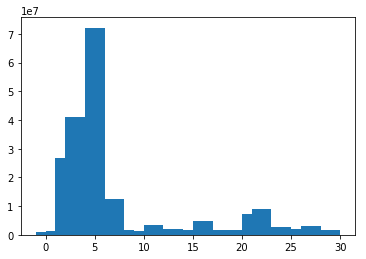

In [77]:
plt.bar(classes_freq_dictionary.keys(), classes_freq_dictionary.values(), width=2,);

In [0]:
weight_to_classes = 

In [0]:
classes_freq_dictionary

### Defining U-net

In [0]:
def make_block(in_channels, out_channels):
    block = nn.Sequential(nn.ReplicationPad2d(1),
                              nn.Conv2d(in_channels, out_channels, 3),
                              nn.ReLU(),
                              nn.BatchNorm2d(out_channels),
                              nn.ReplicationPad2d(1),
                              nn.Conv2d(out_channels, out_channels, 3),
                              nn.ReLU(),
                              nn.BatchNorm2d(out_channels)
                             )
    if (device.type == "cuda"):
        block.type(torch.cuda.FloatTensor)
    return block

In [0]:
class UNet(nn.Module):
    def __init__(self, basic_chl,num_classes = 30,image_channels = 3):
        super(UNet, self).__init__()
        
        #Calculate channels based on basic channel
        BL1_chl, BL2_chl, BL3_chl, BL4_chl, BL5_chl= [basic_chl * i for i in [1,2,4,8,16]]
        
        #Encoder blocks
        self.ENC_BL1 = make_block(image_channels,BL1_chl)
        self.ENC_BL2 = make_block(BL1_chl,BL2_chl)
        self.ENC_BL3 = make_block(BL2_chl,BL3_chl)
        self.ENC_BL4 = make_block(BL3_chl,BL4_chl)
        self.ENC_BL5 = make_block(BL4_chl,BL5_chl)
        
        #MaxPool for downsampling
        self.MaxPool = nn.MaxPool2d(2,2)
        
        #UpConv for upsampling
        self.UpConv1 = nn.ConvTranspose2d(BL5_chl, BL4_chl, 2, stride = 2)
        self.UpConv2 = nn.ConvTranspose2d(BL4_chl, BL3_chl, 2, stride = 2)
        self.UpConv3 = nn.ConvTranspose2d(BL3_chl, BL2_chl, 2, stride = 2)
        self.UpConv4 = nn.ConvTranspose2d(BL2_chl, BL1_chl, 2, stride = 2)
        
        #Decoder blocks
        self.DEC_BL1 = make_block(BL5_chl,BL4_chl)
        self.DEC_BL2 = make_block(BL4_chl,BL3_chl)
        self.DEC_BL3 = make_block(BL3_chl,BL2_chl)
        self.DEC_BL4 = make_block(BL2_chl,BL1_chl)
        
        # Last convolution
        self.Final_CONV = nn.Conv2d(basic_chl, num_classes, 1)
        
    
    def forward(self,X):
        # Encoder
        ENC_1_out = self.ENC_BL1.forward(X)
        MaxENC_1_out = self.MaxPool.forward(ENC_1_out)
        
        ENC_2_out = self.ENC_BL2.forward(MaxENC_1_out)
        MaxENC_2_out = self.MaxPool.forward(ENC_2_out)
        
        ENC_3_out = self.ENC_BL3.forward(MaxENC_2_out)
        MaxENC_3_out = self.MaxPool.forward(ENC_3_out)
        
        ENC_4_out = self.ENC_BL4.forward(MaxENC_3_out)
        MaxENC_4_out = self.MaxPool.forward(ENC_4_out)
                
        # Bridge to Decoder
        ENC_5_out = self.ENC_BL5.forward(MaxENC_4_out)
        UpENC_5_out = self.UpConv1.forward(ENC_5_out)  
        
        #Decoder
        DEC_1_in = torch.cat((UpENC_5_out,ENC_4_out), dim = 1)
        DEC_1_out = self.DEC_BL1.forward( DEC_1_in)
        UpDEC_1_out = self.UpConv2.forward(DEC_1_out)
        
        
        DEC_2_in = torch.cat((UpDEC_1_out,ENC_3_out), dim = 1)
        DEC_2_out = self.DEC_BL2.forward(DEC_2_in)
        UpDEC_2_out = self.UpConv3.forward(DEC_2_out)
        
        DEC_3_in = torch.cat((UpDEC_2_out,ENC_2_out), dim = 1)
        DEC_3_out = self.DEC_BL3.forward(DEC_3_in)
        UpDEC_3_out = self.UpConv4.forward(DEC_3_out)
        
        DEC_4_in = torch.cat((UpDEC_3_out,ENC_1_out), dim = 1)
        DEC_4_out = self.DEC_BL4.forward(DEC_4_in)
          
        #Final Convolution    
        segmenatation_map = self.Final_CONV.forward(DEC_4_out)
    
        return segmenatation_map
    

### Compute Validation

In [0]:
def compute_validation_accuracy(model, val_loader):
    model.eval()
    
    acc_accum = 0.0
    PIXELS_IN_BATCH = PIXELS_IN_PIC * val_loader.batch_size
    for idx,(X,y) in enumerate(val_loader):
            
        x = X.to(device)
        y = y.to(device)
                
        prediction = torch.argmax( model(x), dim = 1)   
        acc_accum += float(torch.sum(prediction == y))/PIXELS_IN_BATCH
        
    accuracy = acc_accum / val_loader.__len__()    
    return accuracy
  

def visualize_random_sample(model, loader = val_loader,num_samples = 3):
    model.eval()
    random_idx = np.random.choice(loader.sampler.indices, size = num_samples)
    fig, axs = plt.subplots(num_samples,3, figsize=(10,10))
    
    for ax in axs:
      for obj in ax:
          obj.axis("off")
    
    for i,idx in enumerate(random_idx):
        X,y = dataset[idx]
        
        
        axs[i,0].imshow(X.permute(1,2,0))
        axs[i,1].imshow(idx_to_RGB(y, idx_to_arr))
                
        X = X.to(device)
        y = y.to(device)
        
        pred = torch.argmax( model(X.unsqueeze(0)) ,dim=1) 
        axs[i,2].imshow(idx_to_RGB(pred[0].cpu(), idx_to_arr))
        
        
        idx_acc = float(torch.sum(pred == y))/PIXELS_IN_PIC
        print("accuracy on {0} validation example : {1:.2f} ".format(i,idx_acc)) 

accuracy on 0 validation example : 0.03 
accuracy on 1 validation example : 0.03 
accuracy on 2 validation example : 0.02 


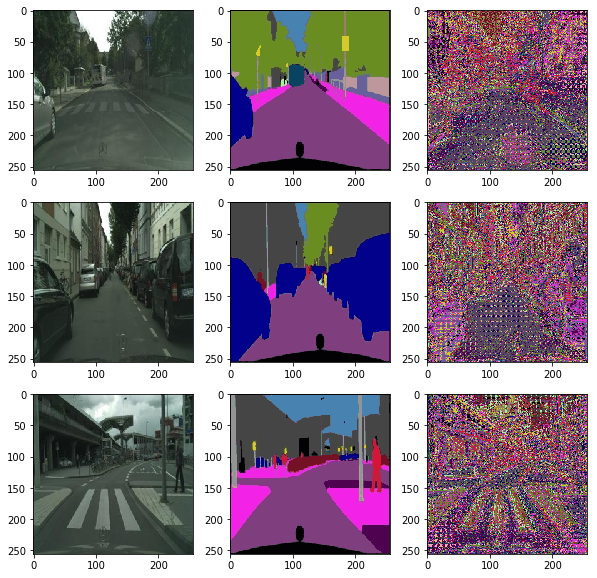

In [136]:
visualize_val_sample(model)

### Training model

In [0]:
def train_model(model, train_loader, val_loader , optimizer, loss_function, num_epochs,sch,gamma):         
    train_loss_history, train_acc_history, val_acc_history = [], [], []
    
    val_acc = 1
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = sch , gamma = gamma)
    
    for epoch in range(num_epochs):
        model.train()
   
        train_acc_accum = 0.0
        running_loss = 0
        scheduler.step()
        for x,y in train_loader:

            x = x.to(device)
            y = y.to(device)
            
            output = model(x) # batch_size x num_classes x height x width
            pred = torch.argmax(output, dim=1)
            
            optimizer.zero_grad()
            
            loss = loss_function(output,y)
            train_acc_accum += float(torch.sum(pred == y))/ (x.shape[0] * PIXELS_IN_PIC) ##ACC_METRIC
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        #print("Train_acc: {0} / {1} ".format(train_acc_accum, train_loader.__len__()) )
        train_acc = train_acc_accum / train_loader.__len__()
        #val_acc = compute_validation_accuracy(model, val_loader)
        #print("Loss_norm: {0} / {1} ".format(running_loss, train_loader.__len__()) ) 
        loss_norm = running_loss / train_loader.__len__()
        
        print("Epoch: {0}, tr_loss = {1:.4f} , tr_acc = {2:.3f} , val_acc {3:.3f} ".format(epoch+1, loss_norm, train_acc, val_acc) )
        
        train_loss_history.append(loss_norm)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        
    return train_loss_history, train_acc_history, val_acc_history

### Toy Dataset for sanity check

In [0]:
### Create toy dataset to check  implementation
np.random.seed(42)

tr_toy_size = 1
val_toy_size = 2 
toy_batch = 1

tr_toy_ind = np.array([123])#np.random.choice(train_indices, size = tr_toy_size) 
val_toy_ind = np.array([123])#np.random.choice(val_indices, size = val_toy_size) 


train_toy_sampler = torch.utils.data.SubsetRandomSampler(tr_toy_ind)
val_toy_sampler = torch.utils.data.SubsetRandomSampler(val_toy_ind) 

train_toy_loader = DataLoader(dataset=dataset, batch_size=toy_batch, sampler= train_toy_sampler)
val_toy_loader = DataLoader(dataset=dataset, batch_size= toy_batch, sampler = val_toy_sampler)

In [0]:
model = UNet(64)
model.to(device)
loss = torch.nn.CrossEntropyLoss()

if (device.type == "cuda"):
    model.type(torch.cuda.FloatTensor)
    loss.type(torch.cuda.FloatTensor)

optim = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay= 1e-5)

Epoch: 1, tr_loss = 1.9826 , tr_acc = 0.657 , val_acc 1.000 
Epoch: 2, tr_loss = 1.2786 , tr_acc = 0.743 , val_acc 1.000 
Epoch: 3, tr_loss = 1.0281 , tr_acc = 0.765 , val_acc 1.000 


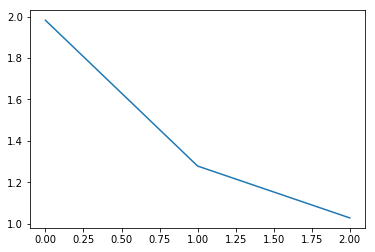

In [144]:
train_loss_history, train_acc_history, val_acc_history = train_model(model,train_loader, val_loader, optim, loss, 3, 40, 0.8)
plt.plot(train_loss_history)

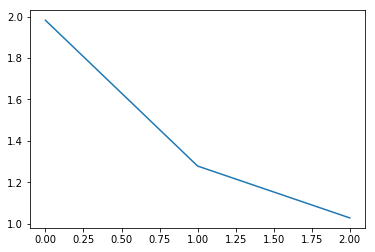

In [145]:
plt.plot(train_loss_history)

In [0]:
compute_validation_accuracy(model, val_loader)

accuracy on 0 validation example : 0.77 
accuracy on 1 validation example : 0.79 
accuracy on 2 validation example : 0.64 


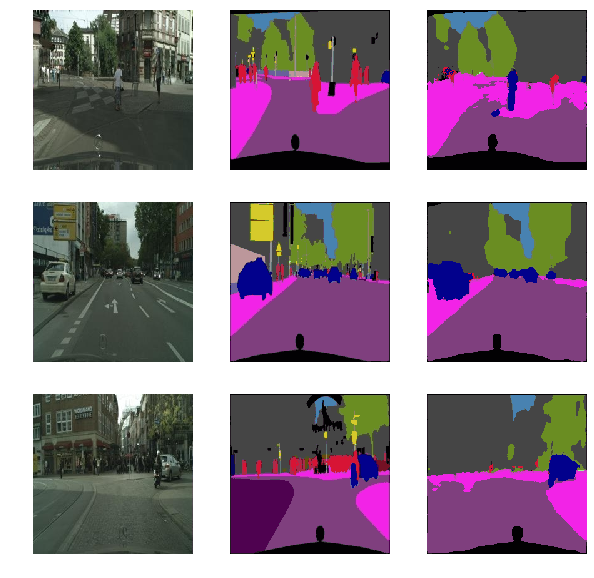

In [171]:
visualize_random_sample(model)

### Random Hyper-parameter search
    Parameters:
    - learning rate
    - weight decay
    
    Algorithm:
    1) Get random sample from search space
    2) Define model with given parameters and train 1 epoch. Check whether training starts well
    3) 
    5) Final search performs N times and return best parameters

In [18]:
dict_params = {
    "lr" : [-5,-1],
    "lr_annealing" : [],
    "L2" : [-6,-1],
    "Dropout" : [-1,0],
}

def Random_search(dict_of_params, N):
    best_score = 0.0
    dict_evaluations
    
    
    for i in range(N):
        
        # Get random parameters
        sample = {par_name:10 ** np.random.uniform(r[0],r[1]) for par_name, r in param_dict.items() }
    
        # Define model
        model = UNet(4)
        optimizer = torch.optim.Adam(model.params(), lr =sample["lr"], weight_decay=sample["L2"])
        # loss function
        
        #perform training
        train_loss_h, train_acc, val_acc_history, = def train_model(model, optimizer, loss_function, 1)
        
        if  (train_loss_h[0] > loss_threshold) :
            dict_evaluations[ ] = train_loss_h
            continue
            # Training exploded and there is no sense to continue
    
        
        if val_acc_history[-1] > best_score:
            best_score = val_acc_history[-1]
            best_params = params
            
        dict_evaluations[tuple([(name,val) for name,val in sample])] = val_acc_history
        
    return dict_evaluations

SyntaxError: ignored